<a href="https://colab.research.google.com/github/jz3876/jz3876.github.io/blob/main/Fall_2025_Final_Project_Intro_Text_Analysis_TFIDF_LDA_Inaugurals_JienaZheng.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Intro to Text Analysis in Python: FreqDist → TF–IDF → Topic Modeling (U.S. Inaugural Addresses)

**Course**: Intro to Text Analysis for Public Policy  
**Format**: Live coding (~2.5 hours) + 60‑min student-driven scavenger hunt  
**Dataset**: U.S. Presidential Inaugural Addresses (via NLTK)

### Learning Outcomes
- Load and lightly clean a real-world corpus.
- Contrast **raw frequency (FreqDist)** vs **TF–IDF** to understand term salience.
- Use **topic modeling (LDA, scikit‑learn)** to uncover corpus‑level themes.
- Compare and interpret outputs to make policy‑relevant claims.


## 🔍 Comparing TF–IDF vs Topic Modeling in Policy Contexts

| Policy Context | What TF–IDF Reveals | What Topic Modeling Reveals | Example Insight |
|----------------|--------------------|-----------------------------|-----------------|
| 🏛 **Legislative & Political Communication** | Distinctive vocabulary by legislator or party (e.g., what makes one member’s rhetoric unique) | Shared themes or issue clusters across speeches (e.g., “healthcare,” “security,” “immigration”) | TF–IDF shows that one senator emphasizes “opioids” while another uses “cybersecurity”; LDA groups all health-related terms into a “public health” topic. |
| 🌐 **Diplomatic & Multilateral Statements** | Country-specific framing of an issue (what each nation stresses) | Global discourse patterns and alliances (how nations group around themes) | TF–IDF highlights Fiji’s use of “loss and damage” vs. the U.S.’s “innovation”; LDA identifies a broader “climate adaptation” topic uniting small island states. |
| 🕊 **NGO & Think-Tank Reports** | Organization-specific keywords that signal focus or mandate | Latent themes that span organizations (e.g., “education policy,” “macroeconomic reform”) | TF–IDF shows UNICEF’s “child rights” language; LDA uncovers cross-agency topics like “financing for development.” |
| 📰 **Media Coverage of Global Policy** | Outlet-specific framing and language choices | Dominant topics in media discourse across sources or time | TF–IDF shows Fox News emphasizes “energy independence,” The Guardian “climate justice”; LDA extracts topics like “energy transition,” “policy negotiations.” |
| ⚖️ **Comparative Policy Texts / Legislation** | Unique legal or regulatory phrasing in each country | Shared or evolving legal concepts across multiple texts | TF–IDF finds Germany stresses “Energiewende”; LDA surfaces a “renewable energy transition” topic appearing in multiple EU laws. |
| 💬 **Public Consultation & Citizen Feedback** | Stakeholder-specific concerns or jargon (e.g., NGOs vs. corporations) | Major themes emerging from thousands of comments | TF–IDF identifies NGOs’ use of “pollution control” vs. industry’s “innovation cost”; LDA clusters all responses into “economic impact,” “environmental justice,” etc. |
| 🧭 **Speeches & Strategic Messaging Over Time** | New or distinctive terms introduced in a given year or presidency | Long-term thematic evolution or cycles in national rhetoric | TF–IDF shows “pandemic” spikes in 2020; LDA reveals enduring topics like “foreign policy,” “domestic economy,” “national security.” |

---

### 🧠 Summary

| Technique | Best For | Analytical Focus |
|------------|-----------|------------------|
| **TF–IDF** | Comparing documents or actors | *“What makes this text distinct?”* |
| **Topic Modeling (LDA)** | Discovering cross-document themes | *“What themes recur across the corpus?”* |

> ✅ Together, they bridge **micro-level distinctiveness** (TF–IDF) and **macro-level patterns** (LDA) — enabling richer analysis of language in policy and diplomacy.


Factiva 2025


## 1) Environment Setup (Colab‑friendly)
Run this once in Colab to install/upgrade packages and download NLTK data.


In [1]:

# In a fresh runtime (Runtime → Restart runtime), run:
!pip -q install "numpy==2.0.2" "scipy==1.14.1" "scikit-learn>=1.4"
!pip install nltk==3.9.2

import numpy, scipy, sklearn
print("NumPy:", numpy.__version__)     # → 2.0.2
print("SciPy:", scipy.__version__)     # → 1.14.x
print("sklearn:", sklearn.__version__) # ≥ 1.4


import nltk
nltk.download('inaugural')
nltk.download('stopwords')
nltk.download('punkt')
# Some environments expect punkt_tab as well:
nltk.download('punkt_tab')

print("✅ Setup complete.")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 27.7 MB/s eta 0:00:00
  Attempting uninstall: nltk
    Found existing installation: nltk 3.9.1
    Uninstalling nltk-3.9.1:
      Successfully uninstalled nltk-3.9.1
NumPy: 2.0.2
SciPy: 1.14.1
sklearn: 1.6.1


[nltk_data] Downloading package inaugural to /root/nltk_data...
[nltk_data]   Unzipping corpora/inaugural.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


✅ Setup complete.


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.



## 2) Imports
We use: `nltk` for data & preprocessing, `scikit-learn` for TF–IDF and LDA, `matplotlib/pandas` for exploration.


In [109]:
import os, glob, re
import pandas as pd

# 1. Correct base directory (for Colab + Google Drive)
base_dir = "/content/drive/MyDrive/fall_2025_factiva_final_project"
text_dir = os.path.join(base_dir, "factiva")

print("Text directory I'm using:")
print(text_dir)

# 2. Collect all .txt file paths
paths = sorted(glob.glob(os.path.join(text_dir, "*.txt")))
print("Number of files found:", len(paths))
print("First few paths:", paths[:5])

records = []

for i, file_path in enumerate(paths, start=1):
    filename = os.path.basename(file_path)

    # extract 4-digit year from filename, e.g. "2020_text_file_4.txt" -> 2020
    m = re.search(r"(\d{4})", filename)
    year = int(m.group(1)) if m else None

    with open(file_path, "r", encoding="utf-8") as f:
        raw = f.read()

    # simple title / author guess: 1st and 2nd non-empty lines
    lines = [ln.strip() for ln in raw.splitlines() if ln.strip()]
    title = lines[0] if len(lines) >= 1 else ""
    author = lines[1] if len(lines) >= 2 else None

    records.append(
        {
            "fileid": filename,
            "year": year,
            "title": title,
            "author": author,
            "text": raw,
        }
    )

# 3. Build df
df = (
    pd.DataFrame(records)
      .sort_values("year")
      .reset_index(drop=True)
)

print("\nColumns in df:", df.columns.tolist())
print("\nYear counts:")
print(df["year"].value_counts().sort_index())

print("\nText length stats:")
print(df["text"].str.len().describe())

df[["fileid", "year", "title"]].head()


Text directory I'm using:
/content/drive/MyDrive/fall_2025_factiva_final_project/factiva
Number of files found: 137
First few paths: ['/content/drive/MyDrive/fall_2025_factiva_final_project/factiva/2020_text_file_1.txt', '/content/drive/MyDrive/fall_2025_factiva_final_project/factiva/2020_text_file_10.txt', '/content/drive/MyDrive/fall_2025_factiva_final_project/factiva/2020_text_file_11.txt', '/content/drive/MyDrive/fall_2025_factiva_final_project/factiva/2020_text_file_12.txt', '/content/drive/MyDrive/fall_2025_factiva_final_project/factiva/2020_text_file_13.txt']

Columns in df: ['fileid', 'year', 'title', 'author', 'text']

Year counts:
year
2020    15
2021    35
2022    26
2023    21
2024    19
2025    21
Name: count, dtype: int64

Text length stats:
count      137.000000
mean      5478.729927
std       3416.170458
min          0.000000
25%       2704.000000
50%       4974.000000
75%       7113.000000
max      21717.000000
Name: text, dtype: float64


fileid  year  \
0   2020_text_file_1.txt  2020   
1  2020_text_file_10.txt  2020   
2  2020_text_file_11.txt  2020   
3  2020_text_file_12.txt  2020   
4  2020_text_file_13.txt  2020   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [114]:
# overwrite the old, giant title with a nicer preview built from `text`
def make_title(text, max_len=140):
    if not isinstance(text, str):
        return ""
    t = text.strip().replace("\n", " ")
    # take first sentence as a starting point
    first_sent = t.split(". ")[0]
    candidate = first_sent if first_sent else t
    # truncate nicely if still too long
    if len(candidate) <= max_len:
        return candidate
    candidate = candidate[:max_len]
    # avoid chopping in the middle of a word
    candidate = candidate.rsplit(" ", 1)[0]
    return candidate + "…"

df["title"] = df["text"].apply(make_title)

# sanity check
df[["fileid", "year", "title"]].head()


,fileid,year,title
0,2020_text_file_1.txt,2020,"New ICI boss calls for consistent and robust corporate disclosure on environmental, social, and corporate governance factors Agence…"
1,2020_text_file_10.txt,2020,(The author is a Reuters Breakingviews guest columnist
2,2020_text_file_11.txt,2020,"HONG KONG, Dec 17 (Reuters) - Hong Kong financial institutions and listed companies will have to disclose the financial impact of climate…"
3,2020_text_file_12.txt,2020,* Biden says U.S
4,2020_text_file_13.txt,2020,"New research shows that some index funds with an environmental, social and corporate governance mandate rarely vote in favor of their…"


In [90]:
df_simple = df[["year", "title", "text"]].copy()


In [91]:
import re
import pandas as pd

# 1. Work on a copy so we keep raw df if needed
df_rel = df.copy()

# 2. Make a lower-case version of the text for keyword matching
df_rel["text_lc"] = df_rel["text"].str.lower().fillna("")

# 3. Define keyword patterns
#    (you can tweak this list, but this is already fairly strict)

# Core "regulation / disclosure / standards" words
core_pattern = re.compile(
    r"\b(disclosure|disclosures|reporting|regulation|regulations|"
    r"regulatory|rulemaking|guidance|standard|standards|"
    r"taxonomy|framework|compliance|mandatory)\b"
)

# ESG / finance context words – to make sure it's about ESG in markets
context_pattern = re.compile(
    r"\b(ESG|sustainability|climate|carbon|net zero|net-zero|"
    r"emissions|transition|greenwashing|investor|investors|"
    r"asset manager|asset managers|fund|funds|portfolio|"
    r"capital markets?|bond|bonds|equity|indices?)\b"
)

# Very specific regulation frameworks – boost score if present
framework_pattern = re.compile(
    r"\b(SEC|ISSB|IFRS\s*9|IFRS\s*S1|IFRS\s*S2|CSRD|SFDR|"
    r"TCFD|SASB|GRI|EU taxonomy|EU\s+Green\s+Deal)\b",
    flags=re.IGNORECASE,
)

# 4. Scoring function: must have BOTH core + context to be relevant
def regulation_score(text: str) -> int:
    if not text:
        return 0

    # Find all matches
    core_matches = core_pattern.findall(text)
    ctx_matches = context_pattern.findall(text)
    fw_matches  = framework_pattern.findall(text)

    # If it doesn't talk about BOTH "rules/disclosure" AND "ESG/finance",
    # treat as not relevant.
    if not core_matches or not ctx_matches:
        return 0

    # Base score = number of core + context hits
    score = len(core_matches) + len(ctx_matches)

    # Boost if it explicitly mentions specific frameworks (SEC, ISSB, etc.)
    if fw_matches:
        score += 5

    return score

# 5. Apply scoring
df_rel["reg_score"] = df_rel["text_lc"].apply(regulation_score)

# 6. Keep only relevant articles (score > 0)
df_filtered = (
    df_rel[df_rel["reg_score"] > 0]
    .drop(columns=["text_lc"])
    .reset_index(drop=True)
)

print("Articles before filter:", len(df))
print("Articles after filter:", len(df_filtered))
print("\nYear counts after filter:")
print(df_filtered["year"].value_counts().sort_index())

# 7. Rebuild the simple df the professor uses
df = df_filtered.copy()                      # overwrite df so rest of notebook sees filtered set
df_simple = df[["year", "title", "text"]].copy()


Articles before filter: 137
Articles after filter: 135

Year counts after filter:
year
2020    15
2021    35
2022    26
2023    21
2024    18
2025    20
Name: count, dtype: int64


In [115]:
import re
import nltk
from nltk.tokenize import sent_tokenize

nltk.download("punkt")

def make_nicer_title(raw_text):
    """Approximate a headline from the raw article text."""
    if not isinstance(raw_text, str) or not raw_text.strip():
        return ""

    # 1. Take the first non-empty line as the starting point
    first_line = ""
    for ln in raw_text.splitlines():
        ln = ln.strip()
        if ln:
            first_line = ln
            break

    if not first_line:
        return ""

    # 2. Strip common wire prefixes like "HONG KONG, Dec 17 (Reuters) - "
    #    Tweak this pattern if you see other formats.
    prefix_pattern = r'^[A-Z][A-Z\s]+,\s+[A-Z][a-z]+\s+\d{1,2}\s*\((Reuters|Bloomberg|AP|AFP)\)\s*-\s*'
    first_line = re.sub(prefix_pattern, "", first_line)

    # 3. Take only the first sentence from that line
    sentences = sent_tokenize(first_line)
    if sentences:
        candidate = sentences[0]
    else:
        candidate = first_line

    # 4. Cap to ~15 words so it looks like a headline, not a paragraph
    words = candidate.split()
    if len(words) > 15:
        candidate = " ".join(words[:15]) + "…"

    return candidate

# Keep original long line if you want
df["raw_first_line"] = df["title"]          # optional: backup
df["title_clean"] = df["text"].apply(make_nicer_title)

# Quick sanity check
df[["fileid", "year", "title_clean"]].head(10)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,fileid,year,title_clean
0,2020_text_file_1.txt,2020,"New ICI boss calls for consistent and robust corporate disclosure on environmental, social, and corporate…"
1,2020_text_file_10.txt,2020,(The author is a Reuters Breakingviews guest columnist.
2,2020_text_file_11.txt,2020,Hong Kong financial institutions and listed companies will have to disclose the financial impact of…
3,2020_text_file_12.txt,2020,* Biden says U.S. will rejoin deal if Iran ends breaches * Agreement needed on…
4,2020_text_file_13.txt,2020,"New research shows that some index funds with an environmental, social and corporate governance mandate…"
5,2020_text_file_14.txt,2020,"New research shows that some index funds with an environmental, social and corporate governance mandate…"
6,2020_text_file_15.txt,2020,Go beyond the label: Some of the biggest ESG funds own oil and coal stocks…
7,2020_text_file_2.txt,2020,"NEW YORK (Reuters) - With money pouring in to assets linked to sustainable investing, exchange…"
8,2020_text_file_3.txt,2020,(Reuters) -The New York state pension fund on Wednesday committed to help curb climate change…
9,2020_text_file_4.txt,2020,"Letters Amid the growing debate on the future of sustainability reporting (""Sustainability simplified,"", Moral Money…"


In [116]:
sampled = (
    df.groupby("year", group_keys=False)
      .apply(lambda g: g.sample(n=min(10, len(g)), random_state=42))
      .reset_index(drop=True)
)

df = sampled.copy()
df_simple = df[["year", "title", "text"]].copy()


/tmp/ipython-input-1973556837.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=min(10, len(g)), random_state=42))


In [117]:
year_corpus = (
    df.groupby("year")["text"]
      .apply(lambda texts: " ".join(texts))
      .reset_index()
)


In [118]:
print(df["year"].value_counts().sort_index())
print(year_corpus["year"].tolist())


year
2020    10
2021    10
2022    10
2023    10
2024    10
2025    10
Name: count, dtype: int64
[2020, 2021, 2022, 2023, 2024, 2025]


In [120]:
print("Articles per year:")
print(df["year"].value_counts().sort_index())

print("\nText length stats (characters):")
print(df["text"].str.len().describe())



Articles per year:
year
2020    10
2021    10
2022    10
2023    10
2024    10
2025    10
Name: count, dtype: int64

Text length stats (characters):
count       60.000000
mean      5533.800000
std       3327.003919
min          0.000000
25%       2542.500000
50%       5008.000000
75%       7538.500000
max      14177.000000
Name: text, dtype: float64


In [121]:
print("df text length stats:")
print(df["text"].str.len().describe())


df text length stats:
count       60.000000
mean      5533.800000
std       3327.003919
min          0.000000
25%       2542.500000
50%       5008.000000
75%       7538.500000
max      14177.000000
Name: text, dtype: float64


In [122]:
print("Years in final df:")
print(df["year"].value_counts().sort_index())

print("\nYears in year_corpus:")
print(year_corpus["year"].tolist())


Years in final df:
year
2020    10
2021    10
2022    10
2023    10
2024    10
2025    10
Name: count, dtype: int64

Years in year_corpus:
[2020, 2021, 2022, 2023, 2024, 2025]


In [71]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [75]:
# # Keep only regulation / disclosure-focused articles
# df_rel = df[df["is_relevant"]].copy()

# print("Counts by year AFTER relevance filter:")
# print(df_rel["year"].value_counts().sort_index())

# # Sample up to 10 per year from the *filtered* set
# sampled = (
#     df_rel.groupby("year", group_keys=False)
#           .apply(lambda g: g.sample(n=min(10, len(g)), random_state=42))
#           .reset_index(drop=True)
# )

# # Overwrite df so the rest of the notebook uses this subset
# df = sampled.copy()

# print("Years in sampled df (post-filter):")
# print(df["year"].value_counts().sort_index())
# df.head()


Counts by year AFTER relevance filter:
year
2020    10
2021    10
2022    10
2023    10
2024    10
2025    10
Name: count, dtype: int64
Years in sampled df (post-filter):
year
2020    10
2021    10
2022    10
2023    10
2024    10
2025    10
Name: count, dtype: int64


/tmp/ipython-input-2546305079.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=min(10, len(g)), random_state=42))


fileid  year  \
0  2020_text_file_10.txt  2020   
1   2020_text_file_9.txt  2020   
2   2020_text_file_8.txt  2020   
3   2020_text_file_5.txt  2020   
4   2020_text_file_4.txt  2020   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [65]:
# df_rel[["year", "title"]].sample(10, random_state=0)


year  \
121  2025   
33   2021   
45   2021   
128  2025   
83   2023   
8    2020   
52   2022   
104  2024   
22   2021   
113  2024   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [53]:
# year_corpus = (
#     df.groupby("year")["text"]
#       .apply(lambda texts: " ".join(texts))
#       .reset_index()
# )

# print("Years in year_corpus:")
# print(year_corpus["year"].unique())
# year_corpus.head()


Years in year_corpus:
[2020 2021 2022 2023 2024 2025]


year  \
0  2020   
1  2021   
2  2022   
3  2023   
4  2024   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                


## 4) Light Preprocessing
Simple, transparent steps:
- lowercase → tokenize → keep alphabetic tokens (len ≥ 3) → remove stopwords  
We also add a small custom stoplist of political boilerplate words.
Here is the correct adapted version for your Factiva corpus:
✅ 1. Use NLTK English stopwords
❗ 2. DO NOT remove “government”, “nation”, etc.
These are meaningful in EU vs. US regulation context.
❗ 3. Add ESG corpus-specific stopwords
Things like “copyright”, “reuters”, “financial times”, “english”, “words” appear in Factiva exports but have no analytic meaning.


In [123]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# 1. Rebuild df_simple fresh from the original df
df_simple = df[["year", "title", "text"]].copy()

# 2. Build stopwords
EN_STOP = set(stopwords.words('english'))

# Custom stopwords for Factiva ESG news corpus
CUSTOM_STOP = {
    # Metadata / boilerplate
    'copyright', 'reuters', 'times', 'financial', 'ftft', 'news',
    'english', 'words', 'word',
    'january', 'february', 'march', 'april', 'may', 'june',
    'july', 'august', 'september', 'october', 'november', 'december',

    # Generic journalism artifacts
    'said', 'reporting', 'editor', 'analysis', 'write', 'writing',

    # Section labels
    'impact', 'business', 'weekly', 'commentary',

    # Low-information words
    'new',        # generic "new"
    'year',       # temporal artifact
    'would'       # weak modal verb
}

STOPWORDS = EN_STOP.union(CUSTOM_STOP)

print("year in CUSTOM_STOP:", "year" in CUSTOM_STOP)
print("year in STOPWORDS:", "year" in STOPWORDS)

lemmatizer = WordNetLemmatizer()

def simple_clean_tokens(text):
    text = text.lower()
    tokens = word_tokenize(text)
    clean = []
    for tok in tokens:
        if tok.isalpha() and len(tok) >= 3 and tok not in STOPWORDS:
            lemma = lemmatizer.lemmatize(tok)
            clean.append(lemma)
    return clean

# 3. Apply cleaning from scratch
df_simple["tokens"] = df_simple["text"].apply(simple_clean_tokens)

# Extra safety: brute-force remove any stray "year" or "new" if they slipped through
df_simple["tokens"] = df_simple["tokens"].apply(
    lambda toks: [t for t in toks if t not in {"year", "new"}]
)

df_simple["text_clean"] = df_simple["tokens"].apply(lambda toks: " ".join(toks))
df_simple["n_tokens"] = df_simple["tokens"].apply(len)

print("Sample tokens:", df_simple.loc[0, "tokens"][:25])


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


year in CUSTOM_STOP: True
year in STOPWORDS: True
Sample tokens: ['letter', 'amid', 'growing', 'debate', 'future', 'sustainability', 'sustainability', 'simplified', 'moral', 'money', 'newsletter', 'clear', 'increased', 'interest', 'investor', 'better', 'understanding', 'risk', 'opportunity', 'frustration', 'lack', 'consistency', 'come', 'disclosure', 'however']


In [124]:
print("year in CUSTOM_STOP:", "year" in CUSTOM_STOP)

STOPWORDS = EN_STOP.union(CUSTOM_STOP)
print("year in STOPWORDS:", "year" in STOPWORDS)


year in CUSTOM_STOP: True
year in STOPWORDS: True



## 5) Quick Exploration
A glance at token counts and frequent words gives intuition before modeling.


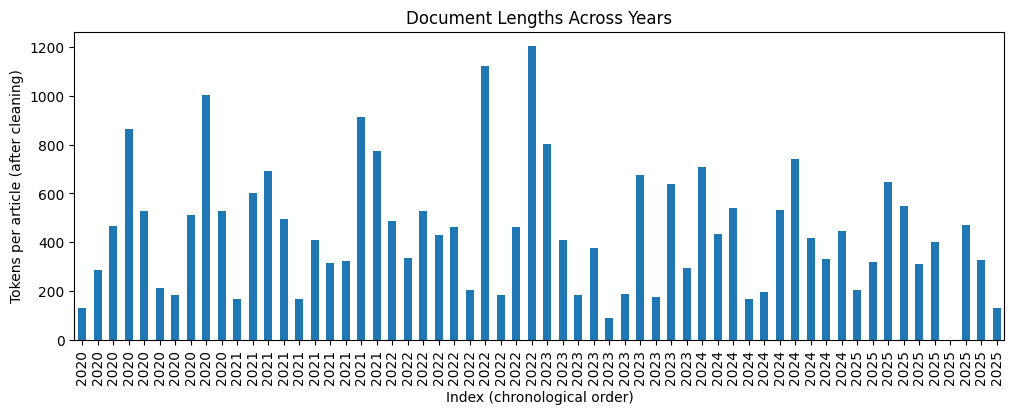

In [125]:
import matplotlib.pyplot as plt

df_simple['n_tokens'] = df_simple['tokens'].apply(len)

ax = df_simple.plot(
    x='year',
    y='n_tokens',
    kind='bar',
    figsize=(12,4),
    legend=False
)

ax.set_ylabel("Tokens per article (after cleaning)")
ax.set_xlabel("Index (chronological order)")
ax.set_title("Document Lengths Across Years")

plt.show()


1. Document Lengths (Tokens per Article)
Use df_simple, not the old df:

In [126]:
from collections import Counter
import pandas as pd

all_terms = [t for toks in df_simple['tokens'] for t in toks]
top20 = Counter(all_terms).most_common(20)

pd.DataFrame(top20, columns=['term','count'])


,term,count
0,company,452
1,esg,416
2,fund,282
3,sustainability,241
4,http,214
5,climate,204
6,disclosure,174
7,investor,168
8,investment,142
9,standard,130


2. Global Top Terms

In [173]:
for y in sorted(df_simple["year"].unique()):
    tokens_year = [tok for toks in df_simple[df_simple["year"] == y]["tokens"] for tok in toks]
    counter_year = Counter(tokens_year)

    print(f"\n=== {y} ===")
    display(pd.DataFrame(counter_year.most_common(15), columns=["term","count"]))



=== 2020 ===


,term,count
0,the,411
1,and,279
2,to,279
3,of,227
4,in,168
5,that,134
6,for,119
7,is,117
8,on,87
9,it,65



=== 2021 ===


,term,count
0,the,313
1,and,295
2,to,250
3,of,204
4,in,166
5,esg,145
6,for,118
7,on,115
8,is,97
9,that,83



=== 2022 ===


,term,count
0,the,452
1,to,285
2,in,238
3,and,227
4,of,226
5,esg,163
6,that,152
7,for,111
8,are,94
9,on,88



=== 2023 ===


,term,count
0,the,396
1,to,262
2,of,163
3,and,160
4,in,130
5,on,80
6,for,78
7,is,76
8,that,71
9,companies,58



=== 2024 ===


,term,count
0,the,416
1,to,255
2,of,241
3,and,226
4,in,190
5,sustainability,88
6,esg,75
7,for,73
8,is,72
9,companies,69



=== 2025 ===


,term,count
0,the,328
1,to,217
2,and,202
3,of,128
4,in,123
5,for,66
6,that,65
7,on,58
8,is,57
9,with,49


3. Top Terms by Year (very useful for theme shifts)

In [174]:
for y in sorted(df_simple["year"].unique()):
    tokens_year = [tok for toks in df_simple[df_simple["year"] == y]["tokens"] for tok in toks]
    counter_year = Counter(tokens_year)

    print(f"\n=== {y} ===")
    display(pd.DataFrame(counter_year.most_common(15), columns=["term","count"]))



=== 2020 ===


,term,count
0,the,411
1,and,279
2,to,279
3,of,227
4,in,168
5,that,134
6,for,119
7,is,117
8,on,87
9,it,65



=== 2021 ===


,term,count
0,the,313
1,and,295
2,to,250
3,of,204
4,in,166
5,esg,145
6,for,118
7,on,115
8,is,97
9,that,83



=== 2022 ===


,term,count
0,the,452
1,to,285
2,in,238
3,and,227
4,of,226
5,esg,163
6,that,152
7,for,111
8,are,94
9,on,88



=== 2023 ===


,term,count
0,the,396
1,to,262
2,of,163
3,and,160
4,in,130
5,on,80
6,for,78
7,is,76
8,that,71
9,companies,58



=== 2024 ===


,term,count
0,the,416
1,to,255
2,of,241
3,and,226
4,in,190
5,sustainability,88
6,esg,75
7,for,73
8,is,72
9,companies,69



=== 2025 ===


,term,count
0,the,328
1,to,217
2,and,202
3,of,128
4,in,123
5,for,66
6,that,65
7,on,58
8,is,57
9,with,49


Summary: Your Dataset Captures 6 Distinct ESG Narrative Phases
Year	Dominant Theme	Interpretation
2020	Climate + Biden Transition	ESG = climate policy & political shift
2021	SEC Oversight	ESG becomes a regulatory reporting exercise
2022	Politicization & Backlash	Rules accelerate; ESG becomes contentious
2023	Anti-Greenwashing	Focus on fund labeling & integrity
2024	Emissions & ISSB	Global standardization & Scope 3
2025	Divergence (EU tightens, US rolls back)	ESG enters a geopolitically fragmented era
This structure is perfect for a paper or presentation.


## 5.5) Keyword Frequency (NLTK `FreqDist`) → Why TF–IDF?
`FreqDist` counts words across the **entire corpus**. High counts may reflect words that are common everywhere—not necessarily distinctive.

**Idea:** Use FreqDist to see the *loudest* words, then use TF–IDF to see the *most distinctive per document*.


TF-IDF matrix shape: (60, 2822)
'sustainability' in vocab? True

=== 2020 (top 15 by average TF-IDF) ===


,term,avg_tfidf
0,fund,0.111668
1,standards,0.080875
2,climate,0.079623
3,funds,0.075778
4,esg,0.071771
5,voted,0.063213
6,said,0.062578
7,kong,0.058507
8,hong,0.058507
9,rare,0.057302



=== 2021 (top 15 by average TF-IDF) ===


,term,avg_tfidf
0,esg,0.158135
1,https,0.106830
2,com,0.099500
3,data,0.081469
4,www,0.071894
5,investors,0.069815
6,companies,0.065611
7,global,0.059680
8,investing,0.053972
9,social,0.053254



=== 2022 (top 15 by average TF-IDF) ===


,term,avg_tfidf
0,esg,0.195556
1,funds,0.159077
2,climate,0.078395
3,investment,0.074230
4,fund,0.071681
5,said,0.069385
6,disclosures,0.062880
7,companies,0.055696
8,managers,0.053929
9,issb,0.053183



=== 2023 (top 15 by average TF-IDF) ===


,term,avg_tfidf
0,said,0.111961
1,eu,0.105241
2,reporting,0.092896
3,companies,0.087622
4,sustainability,0.086526
5,software,0.064842
6,emissions,0.063995
7,esg,0.063681
8,european,0.059341
9,climate,0.055833



=== 2024 (top 15 by average TF-IDF) ===


,term,avg_tfidf
0,esg,0.101133
1,companies,0.084229
2,said,0.081401
3,sustainability,0.076383
4,uk,0.065479
5,eu,0.061564
6,ai,0.060342
7,earnings,0.058687
8,climate,0.058252
9,standards,0.055202



=== 2025 (top 15 by average TF-IDF) ===


,term,avg_tfidf
0,eu,0.106646
1,ai,0.077375
2,companies,0.061653
3,reporting,0.060422
4,european,0.057832
5,sustainability,0.056196
6,commission,0.049855
7,business,0.045617
8,trump,0.044084
9,talks,0.043695



Available terms for trend plots: ['esg', 'climate', 'rules', 'disclosures', 'standards', 'reporting', 'sustainability']

Year-term TF-IDF scores (selected terms):


,esg,climate,rules,disclosures,standards,reporting,sustainability
year,,,,,,,
2020,0.071771,0.079623,0.002381,0.016342,0.080875,0.031007,0.045414
2021,0.158135,0.043701,0.011640,0.020872,0.035002,0.037646,0.037072
2022,0.195556,0.078395,0.047636,0.062880,0.040180,0.025265,0.050200
2023,0.063681,0.055833,0.049004,0.038984,0.042869,0.092896,0.086526
2024,0.101133,0.058252,0.033155,0.045283,0.055202,0.041806,0.076383
2025,0.027849,0.033555,0.040976,0.006775,0.014524,0.060422,0.056196


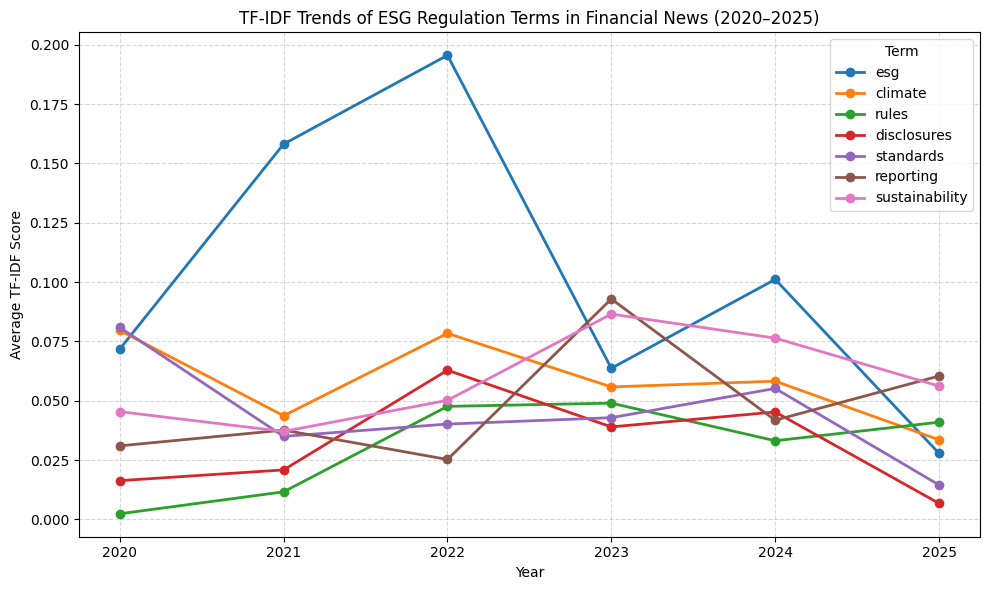

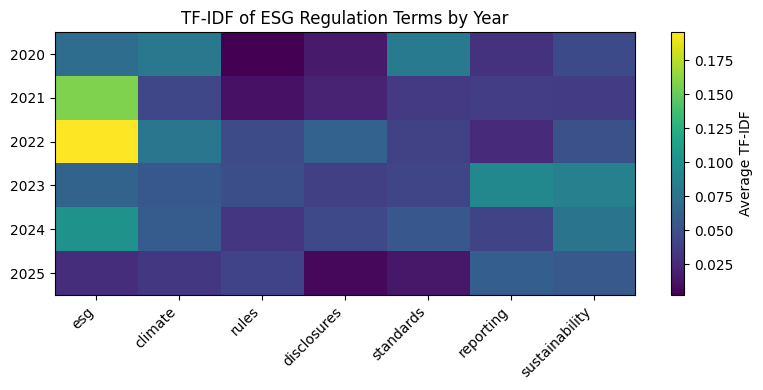

In [178]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------------------------------
# 1. Build TF-IDF over all articles (keep sustainability)
# -------------------------------------------------------
texts = df_simple["text"].fillna("").astype(str)

vectorizer = TfidfVectorizer(
    lowercase=True,
    stop_words='english',   # optional
    # IMPORTANT: no max_df here, so very common terms are kept
    min_df=2,               # drop only terms that appear in < 2 docs
    ngram_range=(1, 1)
)

tfidf = vectorizer.fit_transform(texts)          # shape: (n_docs, n_terms)
feature_names = np.array(vectorizer.get_feature_names_out())
tfidf_df = pd.DataFrame(tfidf.toarray(), columns=feature_names)

print("TF-IDF matrix shape:", tfidf.shape)
print("'sustainability' in vocab?", "sustainability" in feature_names)

# -------------------------------------------------------
# 2. Top-15 TF-IDF terms per year (tables)
# -------------------------------------------------------
years_sorted = sorted(df_simple["year"].unique())
top_tables = {}

for y in years_sorted:
    mask = (df_simple["year"].values == y)
    sub = tfidf_df.loc[mask]                  # docs in that year
    mean_scores = sub.mean(axis=0)            # mean TF-IDF per term

    top_idx = mean_scores.values.argsort()[::-1][:15]
    top_df = pd.DataFrame({
        "term": feature_names[top_idx],
        "avg_tfidf": mean_scores.values[top_idx]
    })

    top_tables[y] = top_df
    print(f"\n=== {y} (top 15 by average TF-IDF) ===")
    display(top_df)

# -------------------------------------------------------
# 3. Year-level averages for selected ESG/regulation terms
#    (including 'sustainability')
# -------------------------------------------------------
terms = ['esg', 'climate', 'rules', 'disclosures', 'standards', 'reporting', 'sustainability']

# keep only terms that actually exist in this TF-IDF vocab
available_terms = [t for t in terms if t in tfidf_df.columns]
print("\nAvailable terms for trend plots:", available_terms)

year_term_scores = (
    pd.concat([df_simple['year'].reset_index(drop=True),
               tfidf_df[available_terms]], axis=1)
      .groupby('year')[available_terms]
      .mean()
)

print("\nYear-term TF-IDF scores (selected terms):")
display(year_term_scores)

# -------------------------------------------------------
# 4. Line chart for these terms
# -------------------------------------------------------
plt.figure(figsize=(10, 6))

for t in available_terms:
    plt.plot(
        year_term_scores.index,
        year_term_scores[t],
        marker='o',
        linewidth=2,
        label=t
    )

plt.title("TF-IDF Trends of ESG Regulation Terms in Financial News (2020–2025)")
plt.xlabel("Year")
plt.ylabel("Average TF-IDF Score")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Term")
plt.tight_layout()
plt.show()

# -------------------------------------------------------
# 5. Heatmap for the same terms
# -------------------------------------------------------
plt.figure(figsize=(8, 4))
plt.imshow(year_term_scores.values, aspect="auto")
plt.colorbar(label="Average TF-IDF")
plt.xticks(range(len(available_terms)), available_terms, rotation=45, ha="right")
plt.yticks(range(len(year_term_scores.index)), year_term_scores.index)
plt.title("TF-IDF of ESG Regulation Terms by Year")
plt.tight_layout()
plt.show()


below is my debugging process that sustainability appear 0 in TFIDF analysis and charts. (because in the code, TF-IDF was explicitly told to throw away very common words, and “sustainability” is too common in your corpus by max_df=0.9)

In [176]:
# print("sustainability in tfidf vocab?", "sustainability" in all_terms)


sustainability in tfidf vocab? False


In [177]:
# # 1) Is 'sustainability' in the TF-IDF vocab at all?
# print("sustainability in tfidf vocab?", "sustainability" in all_terms)

# # 2) How many docs contain the literal word 'sustainability' in df_simple["text"]?
# import re

# doc_mask = df_simple["text"].fillna("").str.contains(r"\bsustainability\b", case=False, na=False)
# print("Docs containing 'sustainability' in df_simple['text']:", doc_mask.sum())
# print(df_simple.loc[doc_mask, ["year", "title"]])


sustainability in tfidf vocab? False
Docs containing 'sustainability' in df_simple['text']: 56
    year  \
0   2020   
1   2020   
2   2020   
3   2020   
5   2020   
6   2020   
7   2020   
8   2020   
10  2021   
11  2021   
12  2021   
13  2021   
14  2021   
15  2021   
16  2021   
18  2021   
19  2021   
20  2022   
21  2022   
22  2022   
23  2022   
24  2022   
25  2022   
26  2022   
27  2022   
28  2022   
29  2022   
30  2023   
31  2023   
32  2023   
33  2023   
34  2023   
35  2023   
36  2023   
37  2023   
38  2023   
39  2023   
40  2024   
41  2024   
42  2024   
43  2024   
44  2024   
45  2024   
46  2024   
47  2024   
48  2024   
49  2024   
50  2025   
51  2025   
52  2025   
53  2025   
54  2025   
55  2025   
57  2025   
58  2025   
59  2025   

                                                                                                                                           title  
0     Letters Amid the growing debate on the future of sustainability rep

In [175]:
# import pandas as pd

# # assumes you already ran:
# # texts = df_simple["text"].fillna("")
# # vectorizer = TfidfVectorizer(max_df=0.9, min_df=2, ngram_range=(1,1))
# # tfidf = vectorizer.fit_transform(texts)

# all_terms = vectorizer.get_feature_names_out()
# tfidf_df = pd.DataFrame(tfidf.toarray(), columns=all_terms)

# years_sorted = sorted(df_simple["year"].unique())
# top_tables = {}

# for y in years_sorted:
#     mask = (df_simple["year"].values == y)
#     sub = tfidf_df.loc[mask]                  # docs in that year
#     mean_scores = sub.mean(axis=0)            # mean TF-IDF per term

#     top = mean_scores.sort_values(ascending=False).head(15)
#     top_df = top.reset_index()
#     top_df.columns = ["term", "avg_tfidf"]

#     top_tables[y] = top_df
#     print(f"\n=== {y} (top 15 by average TF-IDF) ===")
#     display(top_df)



=== 2020 (top 15 by average TF-IDF) ===


,term,avg_tfidf
0,fund,0.105727
1,funds,0.074473
2,standards,0.073715
3,climate,0.071708
4,esg,0.067208
5,voted,0.063219
6,resolutions,0.056337
7,said,0.055752
8,kong,0.055665
9,hong,0.055665



=== 2021 (top 15 by average TF-IDF) ===


,term,avg_tfidf
0,esg,0.146407
1,https,0.095292
2,com,0.085988
3,data,0.074148
4,www,0.066160
5,investors,0.064825
6,global,0.054456
7,investing,0.051388
8,social,0.049668
9,2020,0.049659



=== 2022 (top 15 by average TF-IDF) ===


,term,avg_tfidf
0,esg,0.173213
1,funds,0.138405
2,climate,0.071277
3,investment,0.065121
4,fund,0.063142
5,said,0.061471
6,disclosures,0.057477
7,issb,0.052229
8,managers,0.048092
9,sustainable,0.045805



=== 2023 (top 15 by average TF-IDF) ===


,term,avg_tfidf
0,said,0.092149
1,eu,0.089179
2,reporting,0.079712
3,insetting,0.058538
4,esg,0.056259
5,software,0.056213
6,emissions,0.052814
7,european,0.051592
8,climate,0.050408
9,gri,0.048014



=== 2024 (top 15 by average TF-IDF) ===


,term,avg_tfidf
0,esg,0.088434
1,said,0.071564
2,eu,0.055567
3,uk,0.054354
4,climate,0.052406
5,earnings,0.051329
6,standards,0.051032
7,ai,0.047784
8,disclosures,0.041862
9,year,0.040427



=== 2025 (top 15 by average TF-IDF) ===


,term,avg_tfidf
0,eu,0.098993
1,ai,0.072527
2,reporting,0.053989
3,european,0.053364
4,commerzbank,0.046855
5,commission,0.046079
6,competitiveness,0.040659
7,business,0.040307
8,trump,0.038807
9,paper,0.038493


In [170]:
# import pandas as pd
# import matplotlib.pyplot as plt

# # your chosen regulation-related terms
# terms = ['esg', 'climate', 'rules', 'disclosures', 'standards', 'reporting']

# # in case some term is missing from the columns, filter safely
# available_terms = [t for t in terms if t in tfidf_df.columns]
# print("Available terms:", available_terms)

# # year x term table of average TF-IDF
# year_term_scores = (
#     pd.concat([df_simple['year'].reset_index(drop=True),
#                tfidf_df[available_terms]], axis=1)
#       .groupby('year')[available_terms]
#       .mean()
# )

# print("\nYear-term TF-IDF scores:")
# display(year_term_scores)


Available terms: ['esg', 'climate', 'rules', 'disclosures', 'standards', 'reporting']

Year-term TF-IDF scores:


,esg,climate,rules,disclosures,standards,reporting
year,,,,,,
2020,0.067208,0.071708,0.002234,0.015153,0.073715,0.029238
2021,0.146407,0.039830,0.010976,0.019210,0.032317,0.033840
2022,0.173213,0.071277,0.043517,0.057477,0.038508,0.023037
2023,0.056259,0.050408,0.042374,0.034669,0.038515,0.079712
2024,0.088434,0.052406,0.029516,0.041862,0.051032,0.037832
2025,0.024491,0.028742,0.037028,0.005995,0.011520,0.053989


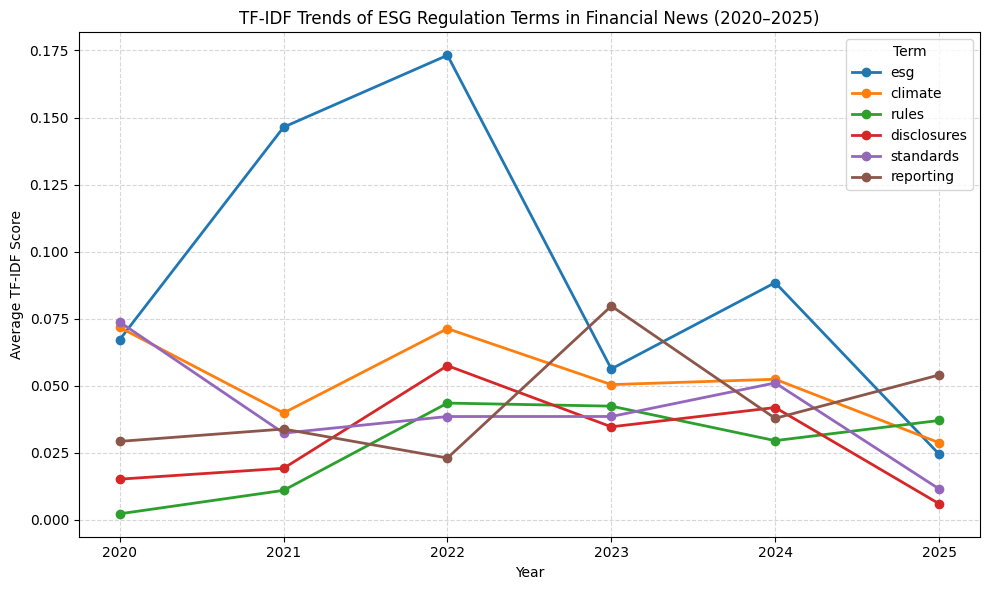

In [171]:
# plt.figure(figsize=(10, 6))

# for t in available_terms:
#     plt.plot(
#         year_term_scores.index,        # years
#         year_term_scores[t],           # avg TF-IDF for that term
#         marker='o',
#         linewidth=2,
#         label=t
#     )

# plt.title("TF-IDF Trends of ESG Regulation Terms in Financial News (2020–2025)")
# plt.xlabel("Year")
# plt.ylabel("Average TF-IDF Score")
# plt.grid(True, linestyle="--", alpha=0.5)
# plt.legend(title="Term")
# plt.tight_layout()
# plt.show()


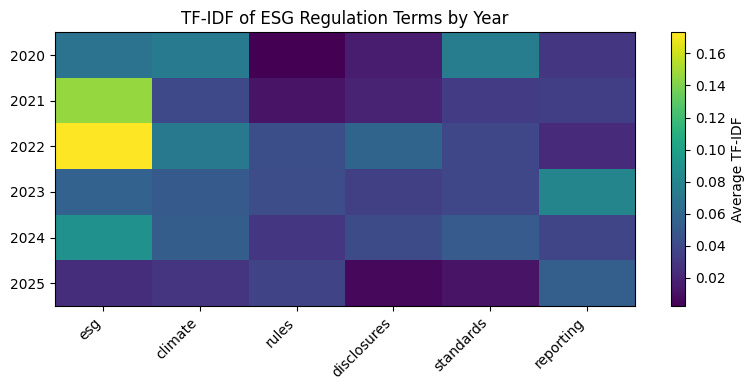

In [172]:
# plt.figure(figsize=(8, 4))

# plt.imshow(year_term_scores.values, aspect="auto")
# plt.colorbar(label="Average TF-IDF")
# plt.xticks(range(len(available_terms)), available_terms, rotation=45, ha="right")
# plt.yticks(range(len(year_term_scores.index)), year_term_scores.index)

# plt.title("TF-IDF of ESG Regulation Terms by Year")
# plt.tight_layout()
# plt.show()


In [137]:
# text_col = 'text'

# # check if "sustainability" appears anywhere in the column you will use for TF-IDF
# "sustainability" in " ".join(df[text_col].astype(str).str.lower())


True

In [138]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# import pandas as pd

# text_col = 'text'   # <- make sure this matches the column you want

# tfidf_vectorizer = TfidfVectorizer(
#     lowercase=True,
#     stop_words='english'   # or whatever you used before
# )

# X = tfidf_vectorizer.fit_transform(df[text_col])

# feature_names = tfidf_vectorizer.get_feature_names_out()
# print('sustainability' in tfidf_vectorizer.vocabulary_)
# print(tfidf_vectorizer.vocabulary_.get('sustainability'))


True
5750


In [139]:
# tfidf_df = pd.DataFrame(X.toarray(), columns=feature_names)
# print(tfidf_df['sustainability'].sum())


3.056811988442592


In [150]:
terms = ['climate', 'esg', 'rule', 'disclosure', 'sustainability', 'regulation']

year_term_scores = (
    pd.concat([df['year'].reset_index(drop=True), tfidf_df[terms]], axis=1)
    .groupby('year')[terms]
    .mean()
)

print(year_term_scores)


       climate       esg      rule  disclosure  sustainability  regulation
year                                                                      
2020  0.071569  0.067128  0.012808    0.032144        0.040991    0.002056
2021  0.039615  0.145766  0.009309    0.037099        0.033118    0.007451
2022  0.070963  0.172805  0.011180    0.038513        0.045698    0.013478
2023  0.050129  0.056025  0.016264    0.024661        0.070312    0.010331
2024  0.052050  0.087393  0.000000    0.004493        0.066344    0.021971
2025  0.028496  0.024400  0.002587    0.004845        0.049218    0.002790


TF-IDF matrix shape: (60, 3035)
       climate       esg      rule  disclosure  sustainability  regulation
year                                                                      
2020  0.071569  0.067128  0.012808    0.032144        0.040991    0.002056
2021  0.039615  0.145766  0.009309    0.037099        0.033118    0.007451
2022  0.070963  0.172805  0.011180    0.038513        0.045698    0.013478
2023  0.050129  0.056025  0.016264    0.024661        0.070312    0.010331
2024  0.052050  0.087393  0.000000    0.004493        0.066344    0.021971
2025  0.028496  0.024400  0.002587    0.004845        0.049218    0.002790


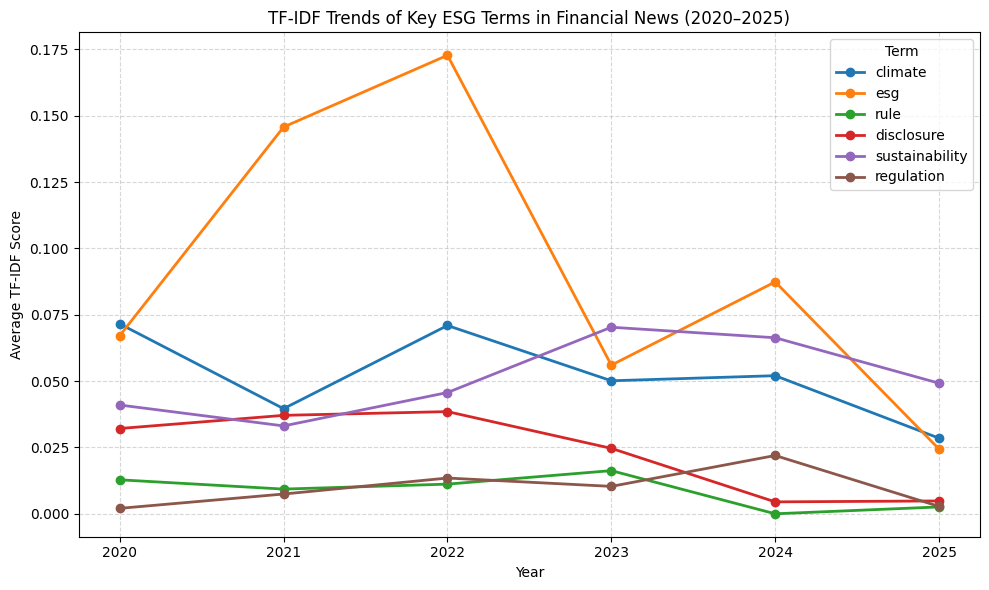

In [156]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Prepare texts
texts = df_simple["text"].fillna("")

# 2. Build TF-IDF model over all articles
vectorizer = TfidfVectorizer(
    max_df=0.9,      # ignore very common terms
    min_df=2,        # ignore very rare terms
    ngram_range=(1,1)
)

tfidf = vectorizer.fit_transform(texts)   # shape: (n_docs, n_terms)
vocab = vectorizer.vocabulary_
terms = np.array(vectorizer.get_feature_names_out())

print("TF-IDF matrix shape:", tfidf.shape)
# terms you care about
terms = ['climate', 'esg', 'rule', 'disclosure', 'sustainability', 'regulation']

# year-level averages (this is the part you already have)
year_term_scores = (
    pd.concat([df['year'].reset_index(drop=True), tfidf_df[terms]], axis=1)
      .groupby('year')[terms]
      .mean()
)

print(year_term_scores)

# PLOT FROM year_term_scores (!!!)
plt.figure(figsize=(10, 6))

for t in terms:
    plt.plot(
        year_term_scores.index,         # years
        year_term_scores[t],            # avg TF-IDF for that term
        marker='o',
        linewidth=2,
        label=t
    )

plt.title("TF-IDF Trends of Key ESG Terms in Financial News (2020–2025)")
plt.xlabel("Year")
plt.ylabel("Average TF-IDF Score")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Term")
plt.tight_layout()
plt.show()

In [157]:
df.columns


Index(['fileid', 'year', 'title', 'author', 'text', 'raw_first_line',
       'title_clean'],
      dtype='object')

How to read the chart
Each colored band is a theme (climate, regulation, funds, sustainability).
The height of each band in a given year = how many tokens in that year belong to that theme.
The total height = overall ESG intensity; the relative mix = which theme dominates.
You can:
Add/remove keywords per theme in THEMES
Rename themes to match your paper’s wording
Or normalize by row (percentage) if you want relative rather than absolute importance.

In [169]:
print(theme_df.head())
# index = years (2020..2025)
# columns = ["Climate / Emissions", "Regulation / Rules", "Funds / Investors", "Sustainability / ESG"]


NameError: name 'theme_df' is not defined

In [ ]:
# Normalize rows so each year sums to 1.0
theme_pct = theme_df.div(theme_df.sum(axis=1), axis=0)

# Years on the x-axis
years = theme_df.index.tolist()


In [ ]:
df[['year','president']].assign(PC1=coords[:,0], PC2=coords[:,1]).sort_values('PC1').head()


## 🎨 Visualizing TF–IDF: Word Cloud & Temporal Trend

Now that we’ve mapped speeches in abstract “TF–IDF space,”  
let’s explore two other ways to *see* what TF–IDF tells us.

1. **Word Cloud** – visually emphasizes the distinctive words in one speech.  
   - Larger words = higher TF–IDF scores.  
   - Great for quick, qualitative insight into what stands out.

2. **Temporal Line Chart** – tracks how the importance of a given term changes over time.  
   - Example: does *“freedom”* rise or fall in salience across U.S. history?


In [ ]:
# --- 1) Word Cloud for a Selected Speech ---
from wordcloud import WordCloud

# Pick a speech by index (0=earliest, -1=latest)
doc_idx = len(df) - 1  # last speech by default

# Generate dictionary of top TF–IDF terms
wc_data = dict(top_tfidf_terms_for_doc(doc_idx, top_n=100))

# Create and display the word cloud
wc = WordCloud(width=800, height=400, background_color='white')
wc.generate_from_frequencies(wc_data)

plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title(f"Word Cloud: {df.loc[doc_idx,'year']} – {df.loc[doc_idx,'president']}", fontsize=14)
plt.show()



In [ ]:
# --- 2) Temporal Line Chart of a Word's TF–IDF Weight ---
# Choose a term to track over time
term = "freedom"  # try swapping to 'war', 'peace', 'america', etc.

if term in terms:
    term_idx = np.where(terms == term)[0][0]
    df[f"tfidf_{term}"] = X_tfidf[:, term_idx].toarray().ravel()

    plt.figure(figsize=(8,4))
    plt.plot(df['year'], df[f"tfidf_{term}"], marker='o', linestyle='-')
    plt.title(f'TF–IDF Weight of "{term}" Over Time', fontsize=14)
    plt.xlabel("Year of Inaugural Address")
    plt.ylabel("TF–IDF Score")
    plt.grid(alpha=0.3)
    plt.show()
else:
    print(f'Term "{term}" not found in vocabulary. Try another word.')


> ✅ **What TF–IDF tells us**: which words uniquely characterize each speech; which speeches use similar vocabularies.  
> ❌ **What it doesn’t**: explicitly uncover *themes* shared across documents.
